# Models stacking pipeline

In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import json
from typing import Dict

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from model import (
    get_pm25_data_for_modelling,
    #split_df_for_ts_modelling_percentage,
    #split_df_for_ts_modelling_date_range
)

## Get data

In [4]:
def read_json(json_path: str) -> Dict:
    """
    Reads JSON file.
    :param json_path: full path to JSON file
    :return: Python dictionary
    """
    with open(json_path, 'r') as infile:
        return json.load(infile)

In [5]:
# Data files: https://github.com/ksatola/air-polution/tree/master/agh/data

def get_pm25_data_for_modelling(model_type: str = 'ml',
                                forecast_type: str = 'h') -> pd.DataFrame:
    """
    Reads HDF file with analytical view prepared for time series or machine learning modelling.
    :param model_type: 'ts' for time series analytical model or 'ml' for machine learning model
    :param forecast_type: 'd' for daily or 'h' for hourly data
    :return: pandas DataFrame
    """
    config = read_json('../config/pm25_model.json')
    data_folder = config['data_folder']

    if model_type == 'ml':
        if forecast_type == 'h':
            data_file_hdf = data_folder + 'dfpm25_2008-2018_ml_24hours_lags.hdf'
        else:
            data_file_hdf = data_folder + 'dfpm25_2008-2018_ml_7days_lags.hdf'
    else:
        if forecast_type == 'h':
            data_file_hdf = data_folder + 'dfpm25_2008-2018_hourly.hdf'
        else:
            data_file_hdf = data_folder + 'dfpm25_2008-2018_daily.hdf'

    df = pd.read_hdf(path_or_buf=data_file_hdf, key="df")
    #logger.info(f'Dataframe loaded: {data_file_hdf}')
    #logger.info(f'Dataframe size: {df.shape}')
    print(f'Dataframe loaded: {data_file_hdf}')
    print(f'Dataframe size: {df.shape}')

    return df

In [6]:
dfd = get_pm25_data_for_modelling('ml', 'd')
dfd.head()

Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_ml_7days_lags.hdf
Dataframe size: (4014, 13)


,t,t-1,t-3,t-4,t-5,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,4.290823,7.381350,5.134971,-16.374909,-47.645172,1,6,0,6,1,6,1,1
1,13.625808,4.290823,17.628909,5.134971,-16.374909,1,7,0,7,2,0,1,1
2,-21.621035,13.625808,7.381350,17.628909,5.134971,1,8,0,8,2,1,1,1
3,8.678291,-21.621035,4.290823,7.381350,17.628909,1,9,0,9,2,2,1,1
4,11.641890,8.678291,13.625808,4.290823,7.381350,1,10,0,10,2,3,1,1


## Train test split

In [7]:
def split_df_for_ml_modelling(data: pd.DataFrame, 
                              target_col: str = 't', 
                              train_size: float = 0.8) -> (pd.DataFrame, 
                                                           pd.DataFrame, 
                                                           pd.DataFrame, 
                                                           pd.DataFrame):
    """
    Splits pandas DataFrame (columns as features, rows as observations) into train/test split 
    data frames separately for independent and dependent features.
    :param data: pandas DataFrame
    :param target_col: name of the target column
    :param train_size: train/test split ratio, 0-1, specifies how much data should be but in the
    train data set
    :return: tuple of four pandas DataFrames: X_train, X_test, y_train, y_test
    """
    # Split dataset into independent variables dataset columns and dependent variable column
    # X = df.iloc[:, 1:]
    # y = df.iloc[:, :1]
    X = data.copy()
    y = X.pop(target_col)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=train_size,
                                                        random_state=123)
    return X_train, X_test, y_train, y_test

In [8]:
# Train test split
X_train, X_test, y_train, y_test = split_df_for_ml_modelling(data=dfd, 
                                                             target_col='t', 
                                                             train_size=0.02) # train_size=0.00024

In [9]:
X_train.shape

(3933, 12)

In [10]:
X_test.shape

(81, 12)

## Models initialization

In [11]:
def get_models_for_regression() -> list:
    """
    Defines a list of regression models to be used in the modelling.
    :return: list of base sklearn models
    """
    models = [LinearRegression(),
              ElasticNet(),
              SVR(gamma='scale'),
              DecisionTreeRegressor(),
              KNeighborsRegressor(),
              AdaBoostRegressor(),
              BaggingRegressor(n_estimators=10),
              RandomForestRegressor(n_estimators=10),
              ExtraTreesRegressor(n_estimators=10)
              ]
    return models

In [12]:
# Define regression models in scope
reg_models = get_models_for_regression()
models = []

for model in reg_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))
('SVR', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
('DecisionTreeRegressor', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'))
('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_siz

## Initial ranking

In [13]:
def score_ml_models(X_train: pd.DataFrame,
                    y_train: pd.DataFrame,
                    models: list,
                    n_splits: int,
                    metric: str,
                    metric_label: str) -> (list, list, list):
    """
    Calculates a metric for a dataset and list of models.
    :param X_train: pandas DataFrame with independent variables
    :param y_train: pandas DataFrame with dependent variable
    :param models: list of models
    :param n_splits: number of splits for kFold cross validation
    :param metric: scoring name as defined in
    https://scikit-learn.org/stable/modules/model_evaluation.html
    :param metric_label: label for the scoring name
    :return: tuple of three lists: output strings, cross validation results for each model,
    model name
    """
    names = []
    results = []
    output = []

    for name, model in models:
        names.append(name)
        try:
        # Not all scoring metrics are available for all models
            kfold = KFold(n_splits=n_splits)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=metric)
            results.append(cv_results)
            output.append(
            f'{name}, {metric_label} {-cv_results.mean()}, (std. dev. {cv_results.std()})')
        except:
            output.append(f'{name} {metric_label} metric unavailable)')

    return output, results, names

In [14]:
%%time
# Perform initial ranking
scores, results, names = score_ml_models(X_train=X_train,
                                         y_train=y_train,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE")
for score in scores:
    print(score)

LinearRegression, RMSE 13.143886676634612, (std. dev. 0.42758394413212353)
ElasticNet, RMSE 13.131853794028634, (std. dev. 0.43576815454789974)
SVR, RMSE 13.823720574691311, (std. dev. 0.2945517705423598)
DecisionTreeRegressor, RMSE 19.15617659638259, (std. dev. 0.8308203555667868)
KNeighborsRegressor, RMSE 14.588892279746142, (std. dev. 0.4463272629786315)
AdaBoostRegressor, RMSE 13.98362680122381, (std. dev. 0.24964742384039304)
BaggingRegressor, RMSE 14.298376666984037, (std. dev. 0.2468847093716878)
RandomForestRegressor, RMSE 14.392480519903694, (std. dev. 0.45607276871301794)
ExtraTreesRegressor, RMSE 14.393524860652239, (std. dev. 0.4362151151877618)
CPU times: user 5.7 s, sys: 255 ms, total: 5.95 s
Wall time: 5.18 s


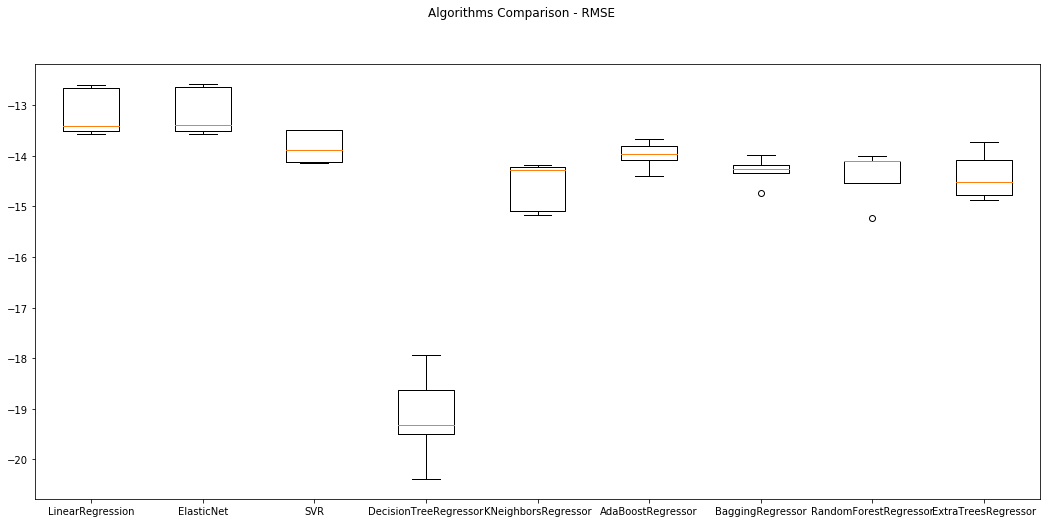

In [15]:
# Compare Algorithms
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Algorithms Comparison - RMSE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('images/ml_comparison_rmse_d.png')
plt.show();

## Hyper-parameter Tuning (2 methods & 3 exemplary models)

In [16]:
%%time
# LinearRegression
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]

CPU times: user 10 µs, sys: 4 µs, total: 14 µs
Wall time: 16 µs


In [17]:
def perform_grid_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [18]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -13.125668218478436 using {'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.7000000000000001, 'max_iter': 10, 'selection': 'random'}
CPU times: user 2min 7s, sys: 14.7 s, total: 2min 22s
Wall time: 36 s


In [19]:
%%time
# AdaBoostRegressor
param_grid = {
    "base_estimator": [models[0][1]],
    "n_estimators": [100, 200],#, 500, 1000, 5000, 10000],
    "loss": ["linear"]#, "square", "exponential"]
}
model = models[5][1]

CPU times: user 31 µs, sys: 4 µs, total: 35 µs
Wall time: 10 µs


In [20]:
def perform_random_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring=scoring,
                            verbose=1, 
                            n_jobs=-1,
                            n_iter=1000)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [21]:
%%time
#AdaBoostRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best: -13.280370252663058 using {'n_estimators': 200, 'loss': 'linear', 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 253 ms, sys: 137 ms, total: 390 ms
Wall time: 1.59 s


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [22]:
%%time
# BaggingRegressor
param_grid = {
    "base_estimator": [models[0][1]],
    "n_estimators": [100, 200],#, 500, 1000, 5000, 10000],
    "bootstrap": [True, False],
    "n_jobs": [-1]
}
model = models[6][1]

CPU times: user 21 µs, sys: 41 µs, total: 62 µs
Wall time: 15 µs


In [23]:
%%time
# BaggingRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: -13.141751073262611 using {'n_jobs': -1, 'n_estimators': 100, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 132 ms, sys: 75.9 ms, total: 207 ms
Wall time: 2.3 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.2s finished


## Evaluate best models on test dataset

In [24]:
best_models = [
    LinearRegression({'selection': 'cyclic', 'max_iter': 10, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}),
    #ElasticNet(**{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}),
    BaggingRegressor(**{'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'bootstrap': True, 'n_estimators': 500, 'n_jobs': -1}),
    #RandomForestRegressor(**{'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'ccp_alpha': 0}),
    #ExtraTreesRegressor(**{'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_depth': 20, 'ccp_alpha': 0})
]

models = []

for model in best_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True,
                 fit_intercept={'alpha': 0.1, 'fit_intercept': True,
                                'l1_ratio': 0.9, 'max_iter': 10,
                                'selection': 'cyclic'},
                 n_jobs=None, normalize=False))
('BaggingRegressor', BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
                 random_state=None, verbose=0, warm_start=False))


In [25]:
scores, results, names = score_ml_models(X_train=X_test,
                                         y_train=y_test,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE")

for score in scores:
    print(score)

LinearRegression, RMSE 13.048955489499978, (std. dev. 1.579505939681471)
BaggingRegressor, RMSE 12.956500052057915, (std. dev. 1.4879616402005373)


## Super learner (stacking)

In [26]:
# Define regression models in scope
models = best_models

for model in models:
    print(type(model).__name__)

LinearRegression
BaggingRegressor


## Analytical view for the Super learner (based on predictions of basic models)

In [27]:
def get_analytical_view_for_meta_model(X_train: pd.DataFrame,
                                       y_train: pd.DataFrame,
                                       models: list,
                                       n_splits: int = 10
                                       ) -> (pd.DataFrame, pd.DataFrame):
    """
    Builds an analytical view based on kFold predictions of base models to be used by another
    model (out-of-fold predictions).
    :param X_train: input variables (pandas DataFrame)
    :param y_train: target variables (pandas DataFrame)
    :param models: list of base models
    :param n_splits: number of KFold splits
    :return: tuple of two pandas DataFrames, one with new input variables, and second with
    corresponding target variables (a copy of y_train)
    """

    # Define split of data
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # Prepare empty data frame with column names (columns as models)
    columns = [type(model).__name__ for model in models]
    # and add target column
    columns = columns.append(y_train.columns[0])
    meta_X = pd.DataFrame(columns=columns)

    cv_fold_number = 1

    for train_indices, test_indices in kfold.split(X_train):
        #logger.debug(f'train: {train_indices}, len: {len(train_indices)}')
        #logger.debug(f'test: {test_indices}, len: {len(test_indices)}')

        #logger.info(f'CV fold number -> {cv_fold_number}')
        print(f'CV fold number -> {cv_fold_number}')
        cv_fold_number += 1

        # Get data
        train_X, test_X = X_train.iloc[train_indices], X_train.iloc[test_indices]
        train_y, test_y = y_train.iloc[train_indices], y_train.iloc[test_indices]
        #logger.debug(f'train_indices {train_indices.shape}')
        #logger.debug(f'test_indices {test_indices.shape}')

        # Add target variable
        fold_yhats = test_y.copy()

        # Fit and make predictions with each sub-model
        for model in models:
            model_name = type(model).__name__
            model.fit(train_X, train_y)
            yhat = model.predict(test_X)
            #logger.info(model_name)
            #logger.debug(f'train_X.shape {train_X.shape}')
            #logger.debug(f'train_y.shape {train_y.shape}')
            #logger.debug(f'yhat.shape {yhat.shape}')
            print(model_name)

            # Build fold-level results data frame, models as features
            fold_yhats[f'{model_name}'] = yhat

        #logger.debug(f'meta_X shape {meta_X.shape}')
        meta_X = pd.concat([meta_X, fold_yhats])

    # Take the target variable out from the dataset
    meta_y = meta_X.pop(y_train.columns[0]).to_frame()

    return meta_X, meta_y

In [28]:
y_train.to_frame()

,t
565,1.986208
3510,0.543645
2845,-19.756946
380,11.018518
809,-4.554063
...,...
1122,25.192456
1346,0.237439
3454,-2.599563
3437,-2.691479


In [29]:
%%time
meta_X, meta_y = get_analytical_view_for_meta_model(X_train, y_train.to_frame(), models, n_splits=10)

CV fold number -> 1
LinearRegression
BaggingRegressor
CV fold number -> 2
LinearRegression
BaggingRegressor
CV fold number -> 3
LinearRegression
BaggingRegressor
CV fold number -> 4
LinearRegression
BaggingRegressor
CV fold number -> 5
LinearRegression
BaggingRegressor
CV fold number -> 6
LinearRegression
BaggingRegressor
CV fold number -> 7
LinearRegression
BaggingRegressor
CV fold number -> 8
LinearRegression
BaggingRegressor
CV fold number -> 9
LinearRegression
BaggingRegressor
CV fold number -> 10
LinearRegression
BaggingRegressor
CPU times: user 2.29 s, sys: 191 ms, total: 2.48 s
Wall time: 4.84 s


In [30]:
meta_X.head()

,LinearRegression,BaggingRegressor
380,9.520451,9.465197
1700,-0.985653,-1.054339
602,1.731567,1.803878
2415,-0.092566,-0.061413
2256,0.607761,0.584574


In [31]:
meta_y.head()

,t
380,11.018518
1700,-8.015220
602,4.828153
2415,-4.309594
2256,18.147460


## Modelling

In [32]:
def fit_base_models(X_train: pd.DataFrame,
                    y_train: pd.DataFrame,
                    models) -> list:
    """
    Fits all base models on the training dataset.
    :param X_train: input variables (pandas DataFrame)
    :param y_train: target variables (pandas DataFrame)
    :param models: list of base models
    :return: list of fitted sklearn models
    """
    for model in models:
        model.fit(X_train, y_train)

    return models

In [33]:
%%time
# Fit base models on entire training dataset
models = fit_base_models(X_train, y_train, models)

CPU times: user 64.4 ms, sys: 10.1 ms, total: 74.5 ms
Wall time: 363 ms


In [34]:
def fit_meta_model(X_train: pd.DataFrame,
                   y_train: pd.DataFrame,
                   meta_model: BaseEstimator = LinearRegression()) -> BaseEstimator:
    """
    Fits a meta model on the training dataset.
    :param X_train: input variables (pandas DataFrame)
    :param y_train: target variables (pandas DataFrame)
    :param meta_model: sklearn regression estimator class
    :return: fitted sklearn model
    """
    model = meta_model
    model.fit(X_train, y_train)
    return model

In [35]:
%%time
# Fit the meta model (using sklearn.linear_model.LinearRegression)
meta_model = fit_meta_model(meta_X, meta_y)

CPU times: user 3.1 ms, sys: 906 µs, total: 4.01 ms
Wall time: 3.16 ms


In [36]:
def get_rmse(observed: pd.Series, predicted: pd.Series) -> np.float:
    """
    Calculates RMSE - Root Mean Squared Error between two series
    :param observed: pandas series with observed values (the truth)
    :param predicted: pandas series with predicted values
    :return: RMSE value
    """
    mse = mean_squared_error(observed, predicted)
    rmse = round(np.sqrt(mse), 4)
    return rmse

In [37]:
def evaluate_models(X_test: pd.DataFrame, y_test: pd.DataFrame, models: list) -> None:
    """
    Evaluates a list of models on a dataset using RMSE (Root Mean Squared Error).
    :param X_test: input variables (pandas DataFrame)
    :param y_test: target variables (pandas DataFrame)
    :param models: list of base models
    :return: None
    """
    for model in models:
        yhat = model.predict(X_test)
        #logger.info(f'{model.__class__.__name__} RMSE {get_rmse(y_test, yhat)}')
        print(f'{model.__class__.__name__} RMSE {get_rmse(y_test, yhat)}')

In [38]:
# Evaluate the base models on the holdout (test) dataset
evaluate_models(X_test, y_test, models)

LinearRegression RMSE 11.305
BaggingRegressor RMSE 11.3016


In [39]:
def predict_with_super_learner(X_test: pd.DataFrame,
                               y_test: pd.DataFrame,
                               models: list,
                               meta_model: BaseEstimator) -> (pd.DataFrame, pd.DataFrame):
    """
    Makes predictions with stacked (meta) model.
    :param X_test: input variables (pandas DataFrame)
    :param y_test: target variables (pandas DataFrame)
    :param models: list of trained base models
    :param meta_model: sklearn model used for stacking
    :return: tuple of two pandas DataFrames, one with meta-model predictions, and second with
    corresponding target variables (a copy of y_test)
    """
    # yhats = y_test.copy()

    # Prepare empty data frame with column names (columns as models)
    columns = [type(model).__name__ for model in models]
    # and add target column
    columns = columns.append(y_test.columns[0])
    models_yhat = pd.DataFrame(columns=columns)

    # Add target variable
    yhats = y_test.copy()

    for model in models:
        model_name = type(model).__name__
        yhat = model.predict(X_test)
        #logger.info(model_name)
        print(model_name)
        #logger.debug(f'yhat.shape {yhat.shape}')

        # Build results data frame, models as features
        yhats[f'{model_name}'] = yhat

    models_yhat = pd.concat([models_yhat, yhats])
    # Take the target variable out from the dataset
    meta_target = models_yhat.pop(y_test.columns[0]).to_frame()

    # Predict
    meta_yhat = meta_model.predict(models_yhat)

    return meta_yhat, meta_target

## Predict with Super learner (on test data)

In [40]:
# Use the super learner (base and meta models) to make predictions on the holdout dataset 
# and evaluate the performance of the approach
meta_yhat, meta_target = predict_with_super_learner(X_test, y_test.to_frame(), models, meta_model)
print(f'Super Learner RMSE {get_rmse(y_test, meta_yhat)}')

LinearRegression
BaggingRegressor
Super Learner RMSE 11.2233
